<a href="https://colab.research.google.com/github/TriaD2221/Image-Based-Smart-Attendance-System/blob/main/attendence_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#Extracts all data from the zip file
import zipfile
import os

zip_path = 'augmented_images.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')


In [21]:
#Sets up the data generators to rescale, augment (rotate/zoom), and load images from the directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = 'data/augmented_images/train'
test_path = 'data/augmented_images/test'

img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 175 images belonging to 5 classes.
Found 80 images belonging to 5 classes.


In [17]:
# Defines the CNN structure, compiles it with the Adam optimizer, and trains it on the loaded images
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1983 - loss: 1.9479 - val_accuracy: 0.2000 - val_loss: 1.3871
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step - accuracy: 0.4086 - loss: 1.2642 - val_accuracy: 0.7750 - val_loss: 0.5641
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 631ms/step - accuracy: 0.7795 - loss: 0.5726 - val_accuracy: 0.9250 - val_loss: 0.3457
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.8697 - loss: 0.3421 - val_accuracy: 0.9500 - val_loss: 0.1597
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - accuracy: 0.8692 - loss: 0.4859 - val_accuracy: 0.9000 - val_loss: 0.6305
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - accuracy: 0.8987 - loss: 0.3852 - val_accuracy: 0.9875 - val_loss: 0.0715
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 822ms/step - accuracy: 0.9278 - loss: 0.2776 - val_accuracy: 0.9875 - val_loss: 0.0950
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 612ms/step - accuracy: 0.9413 - loss: 0.1830 - val_accuracy: 1.0000 - val_loss: 0

In [19]:
# Exports the trained weights and architecture into a reusable .h5 file format
model.save('facial_recognition_model.h5')


In [5]:
from google.colab import files
uploaded = files.upload()


Saving test2.jpg to test2 (1).jpg


In [6]:
#Loads, resizes, and prepares a single image for model prediction by normalizing pixels and adding a batch dimension
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('/content/test2.jpg', target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)


In [10]:
prediction = model.predict(img_array)
confidence = np.max(prediction) * 100
predicted_class = np.argmax(prediction)

print(f"Predicted class: {labels[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: jaimin_train
Confidence: 99.93%


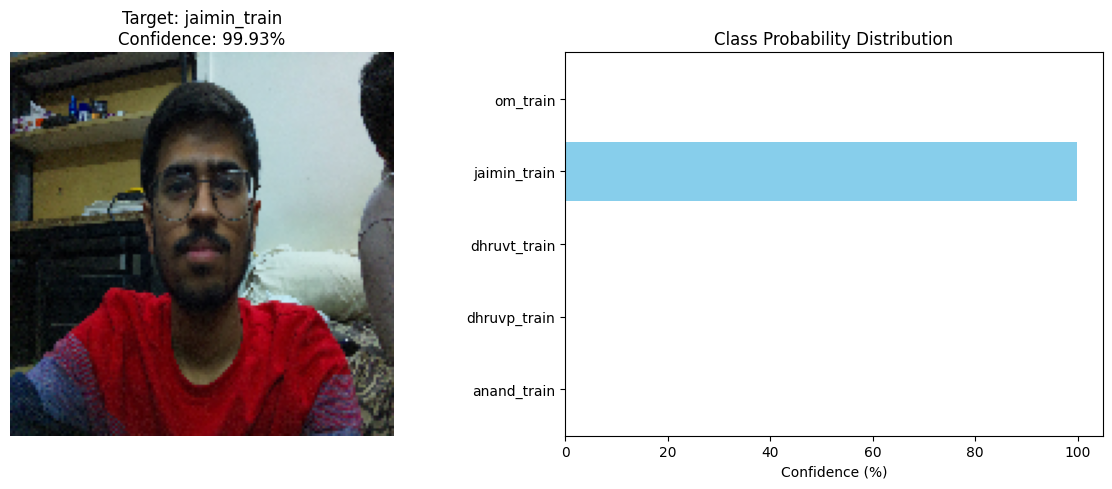

In [11]:
#Displays the test image alongside a horizontal bar chart showing the model's confidence levels for each person category
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Target: {labels[predicted_class]}\nConfidence: {confidence:.2f}%")
plt.axis('off')

plt.subplot(1, 2, 2)
y_pos = np.arange(len(labels))
plt.barh(y_pos, prediction[0] * 100, align='center', color='skyblue')
plt.yticks(y_pos, labels)
plt.xlabel('Confidence (%)')
plt.title('Class Probability Distribution')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


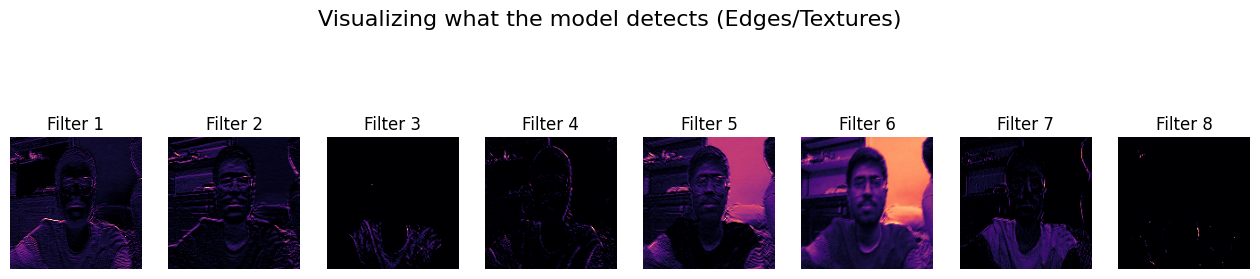

In [13]:
#Visualizes the first layer's feature maps to show the specific edges, textures, and patterns the CNN detects in the image
import tensorflow as tf
import matplotlib.pyplot as plt

first_layer_output = model.layers[0].output
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=first_layer_output)

activations = activation_model.predict(img_array)

plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(activations[0, :, :, i], cmap='magma')
    plt.axis('off')
    plt.title(f"Filter {i+1}")

plt.suptitle("Visualizing what the model detects (Edges/Textures)", fontsize=16)
plt.show()